## PCA analysis of two lung cancer sets

Here we are perfoming a PCA of two different datasets within the TCGA. We will first merge the two datasets and subsequently try to separate the samples based on their principal components.

First we retrieve our two TCGA lungcancer data from cbioportal.org. One of the sets are from [Lung Adenocarcinomas](https://en.wikipedia.org/wiki/Adenocarcinoma_of_the_lung) and the other is from [Lung Squamous Cell Carcinomas](https://en.wikipedia.org/wiki/Squamous-cell_carcinoma_of_the_lung).

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import urllib.request
import tarfile

import requests

def track_dl(url,tar):
    response = requests.get(url, stream=True)
    with open(tar, "wb") as handle:
        for data in response.iter_content():
            handle.write(data)

def get_data(path,url,file):
    try:
        df = pd.read_csv(path)
    except:
#        urllib.request.urlretrieve(url, "my.tar.gz")
        track_dl(url, "my.tar.gz")
        tf = tarfile.open("my.tar.gz")
        tf.extract(file)
        df = pd.read_csv(file, sep="\t")
        df.to_csv(path)
    df.dropna(axis=0, how='any', inplace=True)
    df.set_index('Hugo_Symbol', inplace=True)
    df.drop(columns=['Unnamed: 0', 'Entrez_Gene_Id'], inplace=True)
    return df

luad = get_data("luad.tsv", 'http://download.cbioportal.org/luad_tcga_pan_can_atlas_2018.tar.gz',"data_RNA_Seq_v2_expression_median.txt")
lusc = get_data("lusc.tsv", 'http://download.cbioportal.org/lusc_tcga_pan_can_atlas_2018.tar.gz',"data_RNA_Seq_v2_expression_median.txt")

We now merge the datasets, and see too that we only include transcripts that are measured in all the carcinomas with an count larger than 0.

In [2]:
combined = pd.concat([lusc, luad], axis=1, sort=False)
combined.dropna(axis=0, how='any', inplace=True)
combined = combined.loc[~(combined<=0.0).any(axis=1)]
combined = pd.DataFrame(data=np.log2(combined),index=combined.index,columns=combined.columns)

Make a PCA with a SVD.

In [3]:
from numpy.linalg import svd
X = combined.values
Xm = np.tile(np.mean(X, axis=1)[np.newaxis].T, (1,X.shape[1]))
U,S,Vt = svd(X-Xm, full_matrices=True, compute_uv=True)


First we plot the Eigen genes. These illustrate the linear combinations of genes that explains the variance of the genes. First one describes the most, the second explains most of the variance when the variance of the first gene-compination is removed. Here we only explore the first two component, but one could plot the other ones as well. 

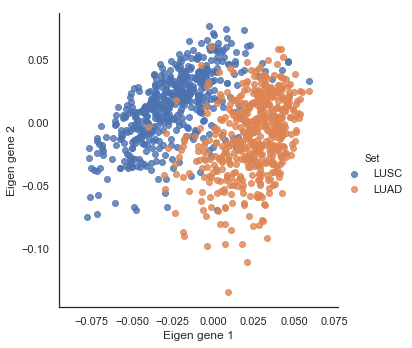

In [4]:
transformed_patients = pd.DataFrame(data=Vt[0:2,:].T,columns=["Eigen gene 1","Eigen gene 2"],index=list(lusc.columns) + list(luad.columns))
transformed_patients["Set"]= (["LUSC" for _ in lusc.columns]+["LUAD" for _ in luad.columns])

sns.set(rc={'figure.figsize':(10,10)})
sns.set_style("white")
#sns.set_context("talk")

sns.lmplot("Eigen gene 1","Eigen gene 2", hue='Set', data=transformed_patients, fit_reg=False)

Here we see a non-complet separation of the patients based on their two first eigengenes. This means that the patients gene expression differ and that diference is covered by the first two principal components.

Lets explore which genes that are most reponsible for that difference. We can do so by investigating their Eigen patients.

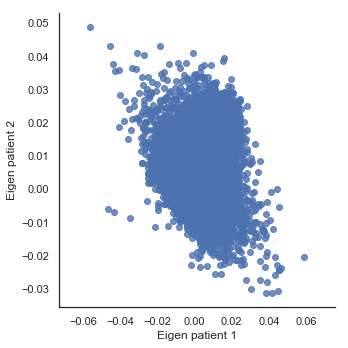

In [5]:
transformed_genes=pd.DataFrame(data=U[:,0:2], index = combined.index, columns = ["Eigen patient 1","Eigen patient 2"])
sns.lmplot("Eigen patient 1","Eigen patient 2", data=transformed_genes, fit_reg=False)

The genes pointing in a positive direction for the two components are:

In [6]:
transformed_genes.idxmax(axis=0)

Eigen patient 1    SFTPB
Eigen patient 2    KRT17
dtype: object

The genes pointing in a negative direction for the two components are:

In [7]:
transformed_genes.idxmin(axis=0)

Eigen patient 1    KRT17
Eigen patient 2     RGL3
dtype: object